In [4]:
%matplotlib inline
%load_ext rpy2.ipython
import os

GIMME_DIR = "/Volumes/WorkDrive/gimmeSAD"
SIMOUT_DIR = os.path.join(GIMME_DIR, "new_sims/")


os.chdir(GIMME_DIR)
import gimmeSAD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import glob

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Gather all the simulations into one huge simout file

In [28]:
REF_TABLE = os.path.join(SIMOUT_DIR, "priors.txt")
if True:
#if not os.path.exists(REF_TABLE):
    outfile = open(REF_TABLE, "w")

    files = glob.glob(SIMOUT_DIR + "*/sumstats.txt")
    numsims = 0
    outfile.write(open(files[0]).readlines()[0])
    for f in files:
        lines = open(f).readlines()[1:]
        numsims += len(lines)
        outfile.write("".join(lines))
        outfile.write("\n")
    outfile.close()

    print("Processed {} simulations.".format(numsims))

Processed 132408 simulations.


## Do the abc in R cuz python abc packages suck
https://www.datacamp.com/community/blog/jupyter-notebook-r#gs.CkjgxoE

## Load the data into R

In [29]:
%%R -i REF_TABLE
## Have to install the abc package the first time
## install.packages("abc")
library(abc)

## fill adds NA for any incomplete row
PRIOR <- read.table(REF_TABLE, header=TRUE, fill=TRUE)
print(PRIOR[1,])


     K           c  step     X.equil colrate extrate     shannon bin_0 bin_1
1 1107 0.001054573 10000 0.008130081   9e-04   7e-04 -0.05005643     1     1
  bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1     0     0     0     0     0     0     0     1


## Estimate % equilibrium using shannon index and 1d pi vector

### Ignore this first cell.

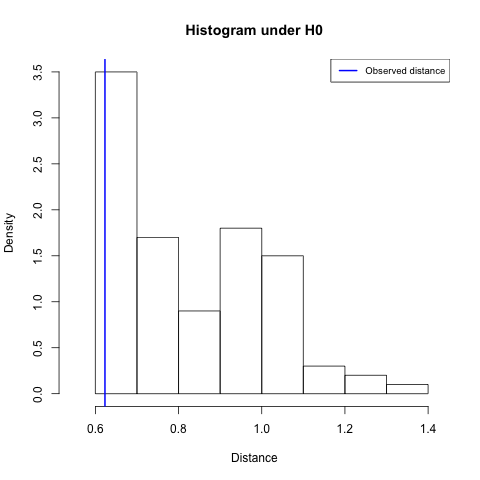

In [14]:
%%R
## Ignore this one
res.gfit = gfit(target=OBS[,1], sumstat=PRIOR[,7], statistic=mean, nb.replicate=100)
plot(res.gfit, main="Histogram under H0")

### Rejection

Prediction error based on a cross-validation sample of 50

             eq
0.05 0.08542626
0.1  0.16229266
0.5  1.05219970


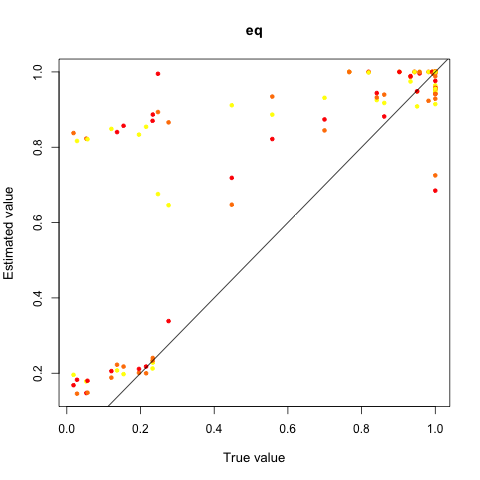

In [12]:
%%R
cv.res.rej <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=c(.05,.1, 0.5), method="rejection")
print(summary(cv.res.rej))
plot(cv.res.rej)

### Loclinear regression

In [94]:
%%R
#cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=c(.01, .05,.1, 0.5), method="loclinear")
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=.005, method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)


Error in lsfit(scaled.sumstat[wt1, ], log(residuals^2), wt = weights) : 
  NA/NaN/Inf in 'y'


/usr/local/opt/miniconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in lsfit(scaled.sumstat[wt1, ], log(residuals^2), wt = weights) : 
  NA/NaN/Inf in 'y'

  warnings.warn(x, RRuntimeWarning)


### Neuralnet (slow)

In [ ]:
%%R
## This is slow even on toy data
cv.res.net <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=10, tols=c(.01, .05,.1, 0.5), method="neuralnet")
print(summary(cv.res.net))
plot(cv.res.net)

KeyboardInterrupt: 

KeyboardInterrupt: 

KeyboardInterrupt: 

## Do the ABC

Call: 
abc(target = OBS, param = data.frame(eq = PRIOR[, "X.equil"]), 
    sumstat = PRIOR[, 7:17], tol = 0.005, method = "loclinear")
Data:
 abc.out$adj.values (445 posterior samples)
Weights:
 abc.out$weights

                           eq
Min.:                  0.5342
Weighted 2.5 % Perc.:  0.7082
Weighted Median:       0.8414
Weighted Mean:         0.8383
Weighted Mode:         0.8447
Weighted 97.5 % Perc.: 0.9537
Max.:                  1.0249
                              eq
Min.:                  0.5341601
Weighted 2.5 % Perc.:  0.7081822
Weighted Median:       0.8413717
Weighted Mean:         0.8383339
Weighted Mode:         0.8446728
Weighted 97.5 % Perc.: 0.9537388
Max.:                  1.0249496


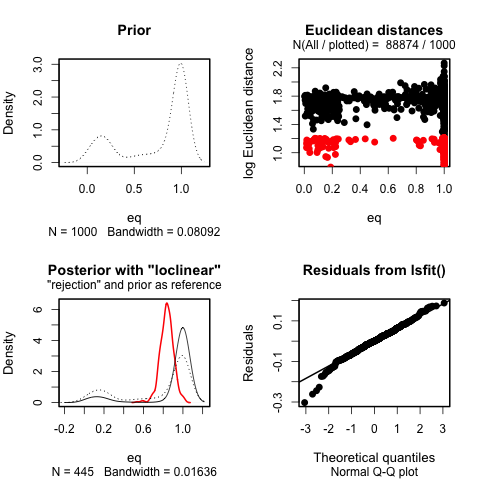

In [82]:
%%R
res.abc = abc(target=OBS, param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,7:17], tol=0.005, method="loclinear")
print(summary(res.abc))
#hist(res.abc)
plot(res.abc, param=PRIOR[,"X.equil"])

## Estimate colonization rate using shannon index and 1d pi vector

Prediction error based on a cross-validation sample of 50

             eq
0.01 0.09100421
0.05 0.08557475
0.1  0.08529741
0.5  0.08213281


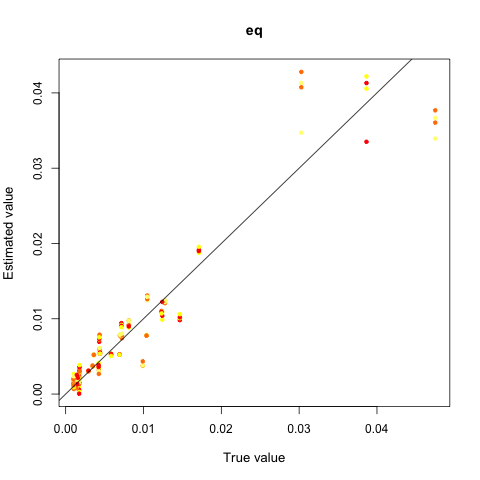

In [7]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"colrate"]), PRIOR[,7:17], nval=50, tols=c(.01, .05, 0.5), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS, param = data.frame(colrate = PRIOR[, "colrate"]), 
    sumstat = PRIOR[, 7:17], tol = 0.005, method = "rejection")
Data:
 abc.out$unadj.values (445 posterior samples)

             colrate
Min.:         0.0010
2.5% Perc.:   0.0010
Median:       0.0016
Mean:         0.0042
Mode:         0.0014
97.5% Perc.:  0.0193
Max.:         0.0453
                  colrate
Min.:        0.0009793056
2.5% Perc.:  0.0009826578
Median:      0.0015742574
Mean:        0.0041886696
Mode:        0.0013763892
97.5% Perc.: 0.0192845625
Max.:        0.0452950000


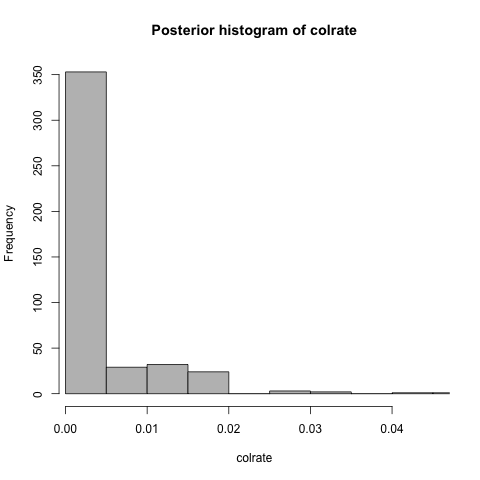

In [85]:
%%R
res.abc = abc(target=OBS, param=data.frame(colrate=PRIOR[,"colrate"]), sumstat=PRIOR[,7:17], tol=0.005, method="rejection")
print(summary(res.abc))
hist(res.abc)
#plot(res.abc, param=PRIOR[,"colrate"])

## Estimate shannon using only 1d pi vector

Prediction error based on a cross-validation sample of 50

          shan
0.01 0.8924514


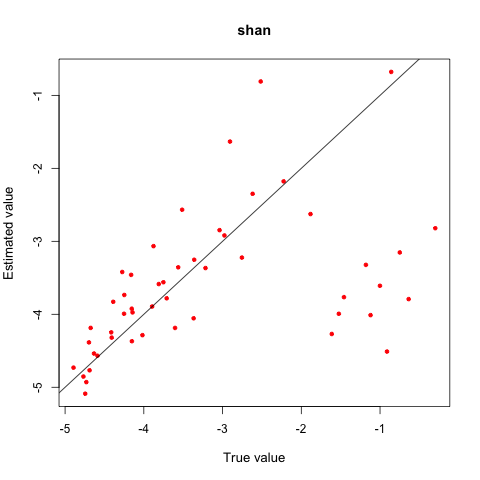

In [31]:
%%R
cv.res.reg <- cv4abc(data.frame(shan=PRIOR[,"shannon"]), PRIOR[,8:17], nval=50, tols=c(.01), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS[2:11], param = data.frame(shan = PRIOR[, "shannon"]), 
    sumstat = PRIOR[, 8:17], tol = 0.005, method = "rejection")
Data:
 abc.out$unadj.values (445 posterior samples)

                shan
Min.:        -4.8804
2.5% Perc.:  -4.3784
Median:      -2.8779
Mean:        -2.8290
Mode:        -2.8649
97.5% Perc.: -0.3566
Max.:        -0.1360
                   shan
Min.:        -4.8804480
2.5% Perc.:  -4.3783983
Median:      -2.8779053
Mean:        -2.8290288
Mode:        -2.8648656
97.5% Perc.: -0.3565601
Max.:        -0.1360395


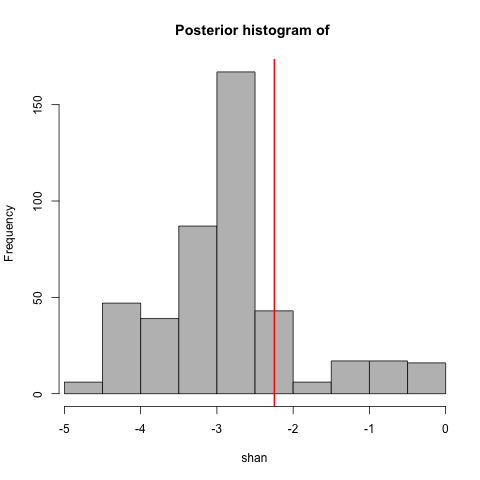

In [86]:
%%R
res.abc = abc(target=OBS[2:11], param=data.frame(shan=PRIOR[,"shannon"]), sumstat=PRIOR[,8:17], tol=0.005, method="rejection")
print(summary(res.abc))
hist(res.abc, true=-2.246206, cap="", breaks=10)
#plot(res.abc, param=PRIOR[,"shannon"])

## Estimate %equil using only 1d pi vector

Prediction error based on a cross-validation sample of 10

            eq
0.01 0.1930333
0.05 0.2208455


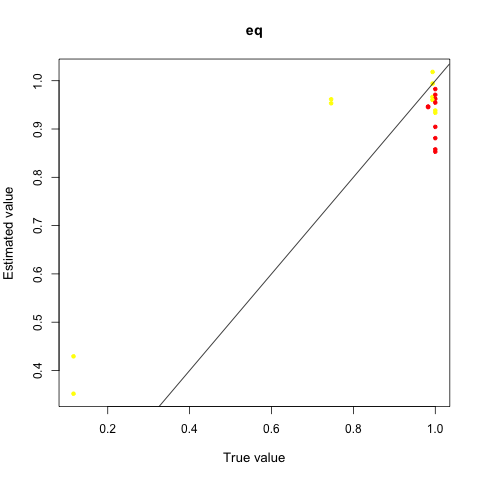

In [34]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,8:17], nval=10, tols=c(.01, .05), method="loclinear", statistic="median")
print(summary(cv.res.reg))
plot(cv.res.reg)

In [98]:
%%R
res.abc = abc(target=OBS[2:11], param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,8:17], tol=0.01, method="loclinear")
print(summary(res.abc))
#hist(res.abc)
plot(res.abc, param=PRIOR[,"X.equil"])

Call: 
abc(target = OBS[2:11], param = data.frame(eq = PRIOR[, "X.equil"]), 
    sumstat = PRIOR[, 8:17], tol = 0.01, method = "rejection")
Data:
 abc.out$unadj.values (949 posterior samples)

                 eq
Min.:        0.0131
2.5% Perc.:  0.0404
Median:      1.0000
Mean:        0.8569
Mode:        0.9968
97.5% Perc.: 1.0000
Max.:        1.0000
                     eq
Min.:        0.01314459
2.5% Perc.:  0.04044360
Median:      1.00000000
Mean:        0.85690217
Mode:        0.99680798
97.5% Perc.: 1.00000000
Max.:        1.00000000
Error in plot.abc(res.abc, param = PRIOR[, "X.equil"]) : 
  Diagnostic plots can be displayed only when method is "loclinear", "neuralnet" or "ridge".FALSE


## Estimate %equil using only shannon

Prediction error based on a cross-validation sample of 50

              eq
0.001 0.04524659
0.005 0.04581155
0.01  0.04626379
0.05  0.04649903
0.1   0.04788377


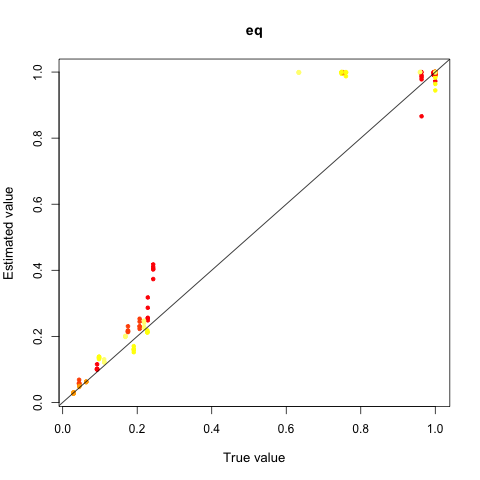

In [12]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7], nval=50, tols=c(.001, .005, .01, .05), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS[, 1], param = data.frame(eq = PRIOR[, "X.equil"]), 
    sumstat = PRIOR[, 7], tol = 0.005, method = "loclinear")
Data:
 abc.out$adj.values (475 posterior samples)
Weights:
 abc.out$weights

                           eq
Min.:                  0.2624
Weighted 2.5 % Perc.:  0.3349
Weighted Median:       0.9949
Weighted Mean:         0.8385
Weighted Mode:         0.9961
Weighted 97.5 % Perc.: 1.0014
Max.:                  1.0014
                              eq
Min.:                  0.2623735
Weighted 2.5 % Perc.:  0.3348801
Weighted Median:       0.9949215
Weighted Mean:         0.8385153
Weighted Mode:         0.9961328
Weighted 97.5 % Perc.: 1.0013968
Max.:                  1.0013999


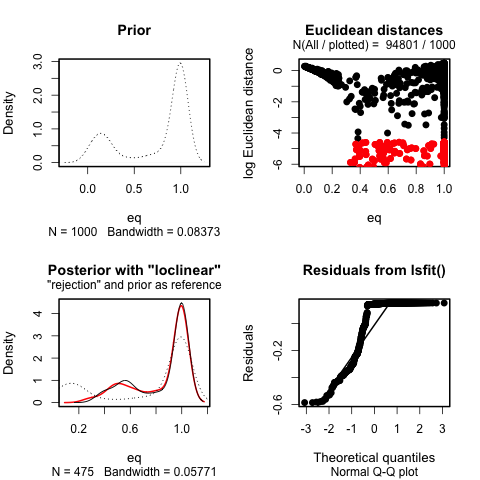

In [96]:
%%R
res.abc = abc(target=OBS[,1], param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,7], tol=0.005, method="loclinear")
print(summary(res.abc))
#hist(res.abc)
plot(res.abc, param=PRIOR[,"X.equil"])

## Estimate island size using shannon and 1d pi vector

Prediction error based on a cross-validation sample of 50

             eq
0.001 0.6453266
0.005 0.3867152
0.01  0.3609488
0.05  0.3812574
0.1   0.3750593


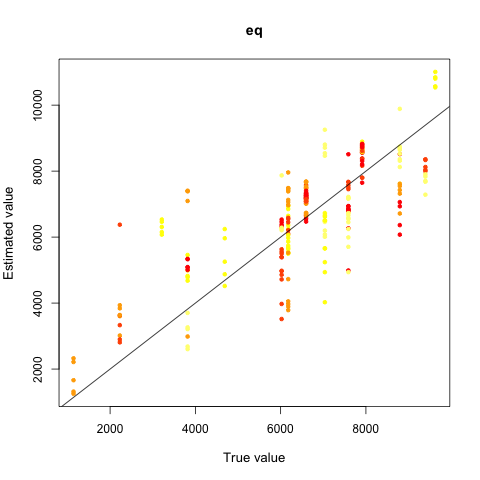

In [74]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"K"]), PRIOR[,7:17], nval=50, tols=c(.001, .005, .01, .05,.1), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS, param = data.frame(eq = PRIOR[, "K"]), sumstat = PRIOR[, 
    7:17], tol = 0.05, method = "loclinear")
Data:
 abc.out$adj.values (4741 posterior samples)
Weights:
 abc.out$weights

                              eq
Min.:                   4237.161
Weighted 2.5 % Perc.:   5431.662
Weighted Median:        7963.660
Weighted Mean:          7908.706
Weighted Mode:          7764.804
Weighted 97.5 % Perc.:  9640.701
Max.:                  11308.365
                              eq
Min.:                   4237.161
Weighted 2.5 % Perc.:   5431.662
Weighted Median:        7963.660
Weighted Mean:          7908.706
Weighted Mode:          7764.804
Weighted 97.5 % Perc.:  9640.701
Max.:                  11308.365


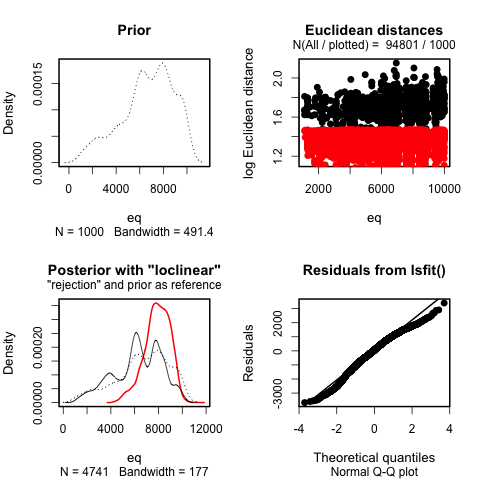

In [95]:
%%R
res.abc = abc(target=OBS, param=data.frame(eq=PRIOR[,"K"]), sumstat=PRIOR[,7:17], tol=0.05, method="loclinear")
print(summary(res.abc))
#hist(res.abc)
plot(res.abc, param=PRIOR[,"K"])

# Co-estimate island size and %equil 

## Estimate island size/%equil using shannon and 1d pi vector

In [ ]:
%%R
cv.res.reg <- cv4abc(data.frame(k=PRIOR[,"K"], eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=c(.001, .005, .01, .05,.1), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Hit <Return> to see next plot: 
Hit <Return> to see next plot: 


Call: 
abc(target = OBS, param = data.frame(k = PRIOR[, "K"], eq = PRIOR[, 
    "X.equil"]), sumstat = PRIOR[, 7:17], tol = 0.05, method = "loclinear")
Data:
 abc.out$adj.values (3679 posterior samples)
Weights:
 abc.out$weights

                                k         eq
Min.:                   3876.3373     0.1729
Weighted 2.5 % Perc.:   5462.2696     0.6628
Weighted Median:        8074.7916     0.8094
Weighted Mean:          7976.6834     0.8072
Weighted Mode:          7728.4728     0.8113
Weighted 97.5 % Perc.:  9545.4466     0.9480
Max.:                  10380.3491     1.1160
                                  k           eq
Min.:                  3.876337e+03 1.729484e-01
Weighted 2.5 % Perc.:  5.462270e+03 6.628112e-01
Weighted Median:       8.074792e+03 8.094355e-01
Weighted Mean:         7.976683e+03 8.071694e-01
Weighted Mode:         7.728473e+03 8.112688e-01
Weighted 97.5 % Perc.: 9.545447e+03 9.479953e-01
Max.:                  1.038035e+04 1.116049e+00


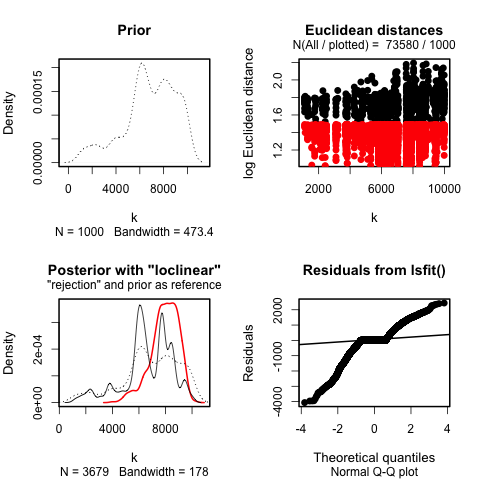

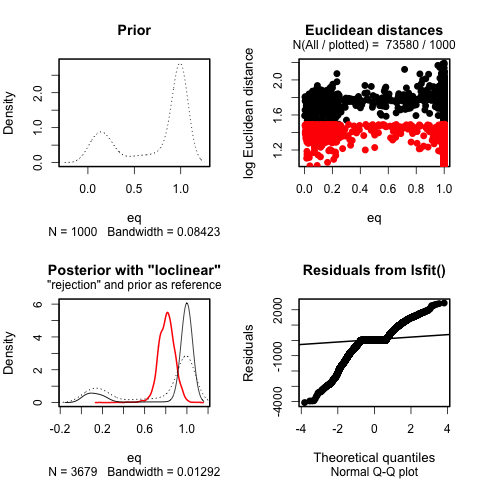

In [57]:
%%R
res.abc = abc(target=OBS, param=data.frame(k=PRIOR[,"K"], eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,7:17], tol=0.05, method="loclinear")
print(summary(res.abc))
#hist(res.abc)
plot(res.abc, param=data.frame(k=PRIOR[,"K"], eq=PRIOR[,"X.equil"]))

# Trash below here

In [27]:
dat = open("new_sims/priors.txt").readlines()
outfile = open("new_sims/newpriors.txt", 'w')
outfile.write(dat[0])
count = 0
for line in dat[1:]:
    try:
        if len(line) ==1:
                count += 1
        elif not line.strip().split()[3] == "1":
                outfile.write(line)
    except:
        pass
print("how many blanks {}".format(count))

how many blanks 508


In [62]:
import math
def shannon(abundances):
    ## Unpack the abundance dist
    abunds = [v for v in abundances.values()]
    tot = np.sum(abunds)
    return -1 * np.sum([x/float(tot) * math.log(x/float(tot)) for x in abunds  if x > 0])

In [78]:
#8   25  7   4   1   3   2   4   1   2
wat = {1:8, 2:25, 3:7, 5:4, 6:1, 7:3, 8:2, 9:4, 10:1, 11:2}
shannon(wat)

[8, 25, 7, 4, 1, 3, 2, 4, 1, 2]
57


1.7994095226462321

In [69]:
math.log(1)

0.0